In [47]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

In [48]:
# Parametri
TICKER = "AAPL"
PERIOD = "10y"

# Scarica dati
data = yf.download(TICKER, period=PERIOD, interval="1d", progress=False, auto_adjust=False)
data = data[["Close"]].copy()


In [49]:
# Calcoliamo SMA (medie mobili)
data["SMA_5"] = data["Close"].rolling(window=5).mean()
data["SMA_10"] = data["Close"].rolling(window=10).mean()
data["SMA_20"] = data["Close"].rolling(window=20).mean()

#print("SMA_5:", data["SMA_5"])

In [50]:
# Creiamo lag features (prezzi passati)
data["Lag_1"] = data["Close"].shift(1)
data["Lag_5"] = data["Close"].shift(5)
data["Lag_10"] = data["Close"].shift(10)

# Rimuoviamo righe con NaN
data.dropna(inplace=True)


In [51]:
# Definizione feature (X) e target (y)
X = data[["SMA_5", "SMA_10", "SMA_20", "Lag_1", "Lag_5", "Lag_10"]]
y = data["Close"]

# Divisione train/test basata sul tempo
train = data.loc[:"2024-12-31"]
test = data.loc["2025-01-01":]

X_train, y_train = train[["SMA_5", "SMA_10", "SMA_20", "Lag_1", "Lag_5", "Lag_10"]], train["Close"]
X_test, y_test = test[["SMA_5", "SMA_10", "SMA_20", "Lag_1", "Lag_5", "Lag_10"]], test["Close"]
print(y_train)
# Standardizzazione
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Ticker            AAPL
Date                  
2015-10-21   28.440001
2015-10-22   28.875000
2015-10-23   29.770000
2015-10-26   28.820000
2015-10-27   28.637501
...                ...
2024-12-24  258.200012
2024-12-26  259.019989
2024-12-27  255.589996
2024-12-30  252.199997
2024-12-31  250.419998

[2314 rows x 1 columns]


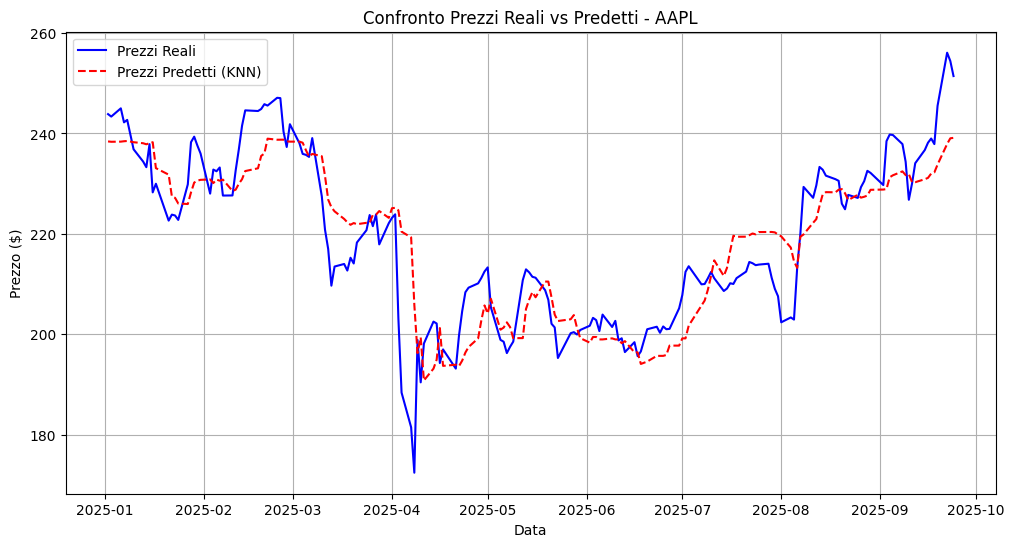

In [55]:
# Modello KNN

knn = KNeighborsRegressor(n_neighbors=int(np.sqrt(len(X_train))))
knn.fit(X_train_scaled, y_train)

# Predizioni
predicted_prices = knn.predict(X_test_scaled)

# Grafico confronto
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Prezzi Reali", color="blue")
plt.plot(y_test.index, predicted_prices, label="Prezzi Predetti (KNN)", color="red", linestyle="--")
plt.title(f"Confronto Prezzi Reali vs Predetti - {TICKER}")
plt.xlabel("Data")
plt.ylabel("Prezzo ($)")
plt.legend()
plt.grid()
plt.show()